In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

## Data processing

In [3]:
df_linear = pd.read_csv('archive/personal_dataset.csv')

letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']

split_index = int(0.8 * len(df_linear))

df = df_linear.sample(frac=1, random_state=42)

train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

y_train = torch.from_numpy(train_df['label'].to_numpy())
train_df = train_df.drop('label', axis = 1)

X_train = torch.from_numpy(train_df.to_numpy())

y_test = torch.from_numpy(test_df['label'].to_numpy())
test_df = test_df.drop('label', axis = 1)

X_test = torch.from_numpy(test_df.to_numpy())

In [4]:
data_transform = transforms.Compose([
    #transforms.RandomResizedCrop(64, scale=(0.99,1), antialias=True),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.1), scale=(0.95, 1)),
    transforms.transforms.RandomPerspective(distortion_scale=0.05, p=0.5),
    #transforms.RandomRotation(degrees=10),
    ])


In [5]:
aug_ratio = 10
X_train_aug = X_train
y_train_aug = y_train

for a in range(aug_ratio):
    aug = data_transform(X_train.view(len(X_train),1,64,64))
    p = torch.rand(size=(len(aug),1))*1.5+0.5
    tmp = torch.pow(aug.view(len(X_train),64*64),p)
    X_train_aug = torch.cat((X_train_aug,tmp), dim=0)
    y_train_aug = torch.cat((y_train_aug,y_train), dim=0)

print("The training dataset contains", len(y_train_aug),"samples")

The training dataset contains 42240 samples


<BarContainer object of 24 artists>

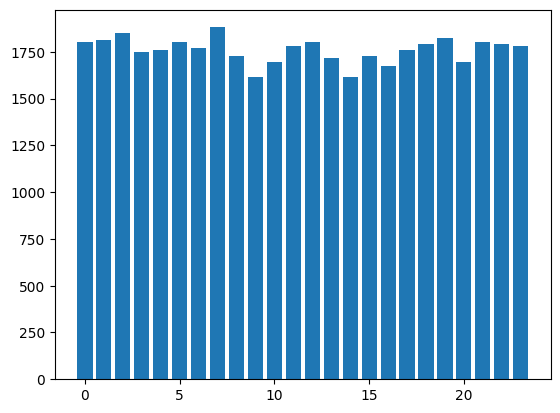

In [6]:
lab, counts= np.unique(y_train_aug, return_counts=True)
plt.bar(lab, counts)

<BarContainer object of 24 artists>

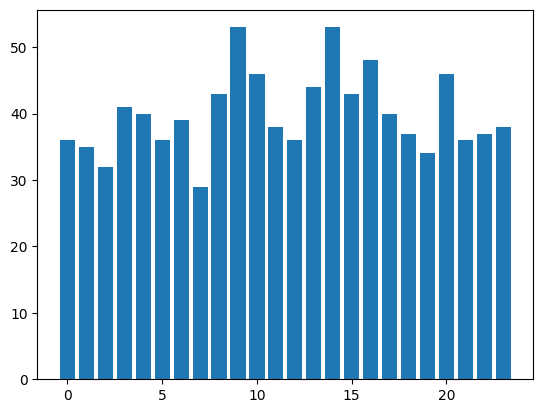

In [7]:
lab, counts= np.unique(y_test, return_counts=True)
plt.bar(lab, counts)

## Visualize and Normalize data

In [8]:
def ImgShow(i, X, y, test=False):
    if not test:

        plt.imshow(X[i].view(64,64), cmap='gray')
        lab = letters[y[i]]
        plt.title(f'Image n.{i},  label: {lab}')
        plt.show()

    else:

        plt.imshow(X[i].view((64,64)), cmap='gray')
        pred = letters[torch.argmax(cnn(X[i].view(1,1,64,64)))]
        lab = letters[y[i]]
        plt.title(f'Image n.{i}, true label: {lab}, pred labe: {pred}')
        plt.show() 

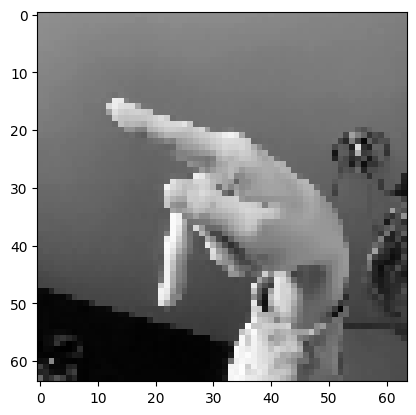

In [9]:
plt.imshow(X_train_aug[100].view(64,64), cmap='gray')

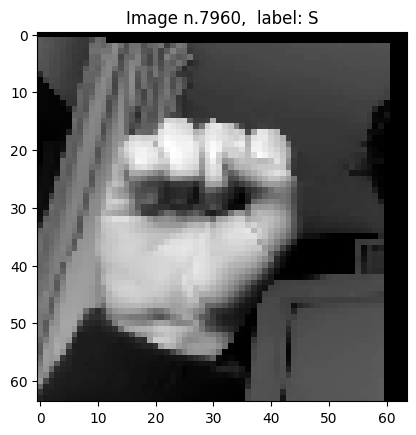

In [37]:
ImgShow( torch.randint(low=0,high=len(X_train_aug), size=(1,)).item(), X_train_aug, y_train_aug)  

In [12]:
def Normalize(X):
    mean = X.float().mean(dim=1, keepdim= True)
    std = X.float().std(dim=1, keepdim= True)
    return (X - mean)/std

In [38]:
X_train_norm = Normalize(X_train_aug)
X_test_norm = Normalize(X_test)
#X_train_norm = X_train_aug/255
#X_test_norm = X_test/255

train_size = int(0.9*len(X_train_aug))
X_val, y_val = X_train_norm[train_size:],  y_train_aug[train_size:]

X_train_norm, y_train = X_train_norm[:train_size], y_train_aug[:train_size]

## Definition of the model

In [50]:
class ASL_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5), padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5), padding=2)
        #self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding=1)
        #self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding=1)
        self.batchnormC = nn.BatchNorm2d(32)
        self.maxpool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(2048 ,512)
        self.batchnormL = nn.BatchNorm1d(512)
        self.out = nn.Linear(512,25)
        self.drop = nn.Dropout(0.05)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)) + self.drop(x))
        x = self.maxpool(F.relu(self.conv2(x)) + self.drop(x))
        x = self.maxpool(F.relu(self.conv3(x)) + self.drop(x))
        #x = self.maxpool(F.relu(self.conv4(x)) + x)
        #x = self.maxpool(F.relu(self.conv5(x)) + x) 
        x = torch.flatten(x, 1)
        #x = self.drop(x)
        x = F.relu(self.fc1(x)) 
        x = self.drop(x)
        x = self.batchnormL(x)
        x = self.out(x)
        
        return x
    
class ASL_CNN_resize(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(5,5), padding=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5,5), padding=2)
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5,5), padding=2)
        #self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5), padding=2)
        self.maxpool3 = nn.MaxPool2d(3,3)
        self.maxpool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(40 ,64)
        self.batchnormL = nn.BatchNorm1d(64)
        self.out = nn.Linear(64,24)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.maxpool3(F.relu(self.conv1(x)) + self.drop(x))
        x = self.maxpool3(F.relu(self.conv2(x)) + self.drop(x))
        x = self.maxpool3(F.relu(self.conv3(x)) + self.drop(x))
        #x = self.maxpool3(F.relu(self.conv4(x)) + self.drop(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x)) 
        x = self.drop(x)
        x = self.batchnormL(x)
        x = self.out(x)
        
        return x

cnn = ASL_CNN_resize().to(device)

print('The model has', sum(p.numel() for p in cnn.parameters() if p.requires_grad), 'trainable parameters' )

The model has 9592 trainable parameters


In [51]:
CELoss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.3, total_iters=100)

## Training procedure

In [52]:
gen = torch.manual_seed(123)

batch = 32
loss_eval = 400
tot_epochs = 10
train_history = []
val_history = []

for epoch in range(tot_epochs):

    running_loss = 0.0
    running_val_loss = 0.0
    for i in range(len(X_train_norm)//batch):
        
        # Batch of training 
        ix = torch.randint(0, len(X_train_norm), (batch,1), generator=gen)
        ixv = torch.randint(0, len(X_val), (batch,1), generator=gen)
        
        cnn.train()
        out = cnn(X_train_norm[ix].view(batch,1,64,64).to(device))
        loss = CELoss(out, y_train_aug[ix].view(batch).to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        cnn.eval()
        with torch.no_grad():
            out = cnn(X_val[ixv].view(batch,1,64,64).to(device))
            loss_val = CELoss(out, y_val[ixv].view(batch).to(device))
            running_val_loss += loss_val.item()
            running_loss += loss.item() 

        scheduler.step()


        if i % loss_eval == loss_eval-1:
            print(f'(epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss={running_loss/loss_eval:.5f} || val loss={running_val_loss/loss_eval:.5f}')
            train_history.append(running_loss)
            val_history.append(running_val_loss)
            running_loss = 0.0
            running_val_loss = 0.0

(epoch: 0), sample: 12800, ---> train loss=2.41588 || val loss=2.55821
(epoch: 0), sample: 25600, ---> train loss=1.56116 || val loss=1.69157
(epoch: 1), sample: 12800, ---> train loss=0.73187 || val loss=0.77745
(epoch: 1), sample: 25600, ---> train loss=0.53161 || val loss=0.53535
(epoch: 2), sample: 12800, ---> train loss=0.34104 || val loss=0.31555
(epoch: 2), sample: 25600, ---> train loss=0.28562 || val loss=0.25934
(epoch: 3), sample: 12800, ---> train loss=0.20106 || val loss=0.19321
(epoch: 3), sample: 25600, ---> train loss=0.18397 || val loss=0.15320
(epoch: 4), sample: 12800, ---> train loss=0.13803 || val loss=0.11900
(epoch: 4), sample: 25600, ---> train loss=0.13373 || val loss=0.11304
(epoch: 5), sample: 12800, ---> train loss=0.11436 || val loss=0.08504
(epoch: 5), sample: 25600, ---> train loss=0.09641 || val loss=0.07254
(epoch: 6), sample: 12800, ---> train loss=0.09024 || val loss=0.06749
(epoch: 6), sample: 25600, ---> train loss=0.09943 || val loss=0.08423
(epoch

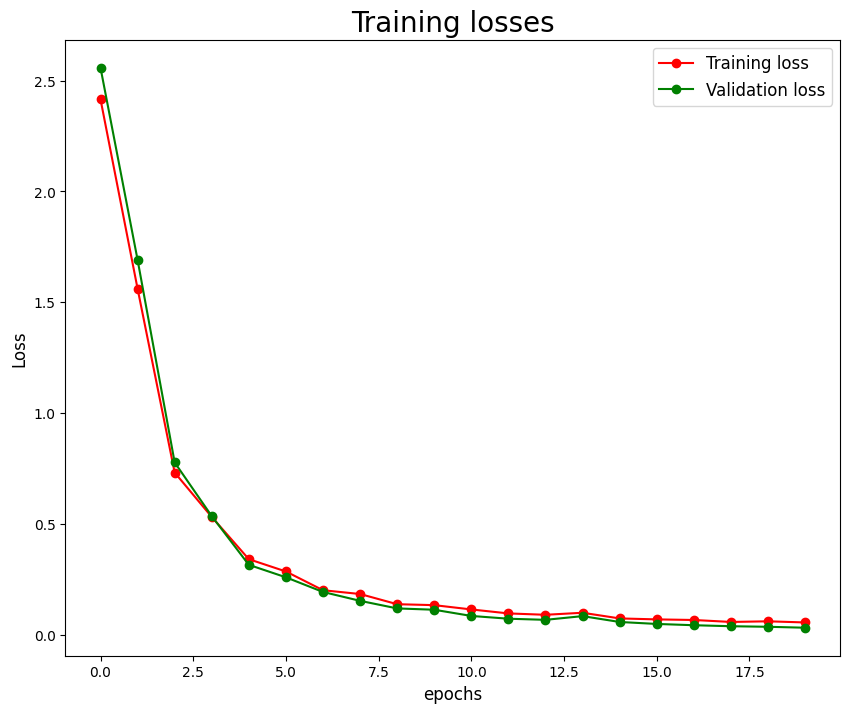

In [54]:
plt.figure(figsize=(10,8))
plt.plot(np.array(train_history)/400, label='Training loss', marker='o', linestyle='-', color='red')
plt.plot(np.array(val_history)/400, label='Validation loss', marker='o', linestyle='-', color='green')
plt.xlabel('epochs',  fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize='large')
plt.title('Training losses', fontsize=20)
plt.show()

## Model's accuracy evaluation

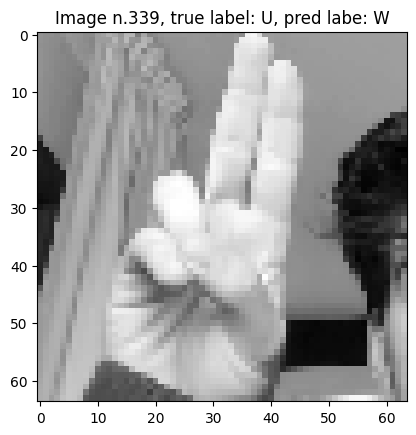

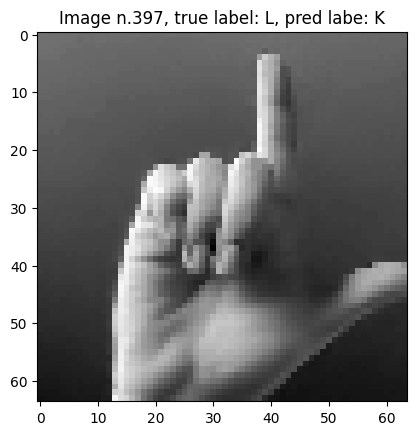

Test Accuracy of the model on test images: 99.791667%


In [55]:
cnn.eval()  
correct = 0
j = 0

cnn.to('cpu')

for i in range(len(X_test_norm)):
    image = X_test_norm[i]
    label = y_test[i]
    out = cnn(image.view(1,1,64,64))
    pred = torch.argmax(out)
    if pred == label:
        correct += 1
    else:
        if j < 5:
            ImgShow(i, X_test_norm, y_test, True)
            j += 1
        

print('Test Accuracy of the model on test images: %.6f%%' % (100.0*correct/len(y_test)))

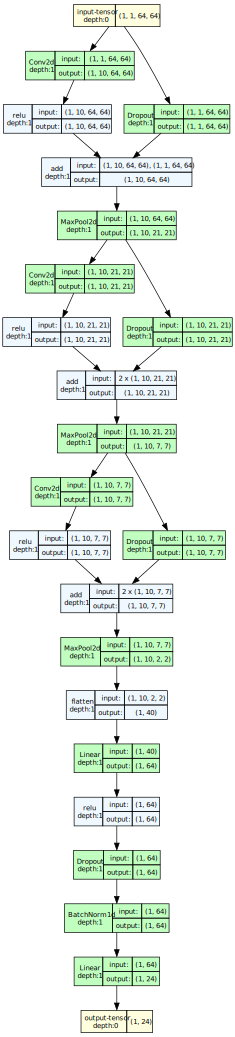

In [44]:
from torchview import draw_graph
import graphviz

model_graph = draw_graph(cnn, input_size=(1,1,64,64), expand_nested=True)
model_graph.visual_graph

In [45]:
HLT

NameError: name 'HLT' is not defined

In [63]:
import cv2 
import mediapipe as mp

mp_hands = mp.solutions.hands
hands = mp_hands.Hands()

font = cv2.FONT_HERSHEY_SIMPLEX
capture = cv2.VideoCapture(0)

offset = 150

if not capture.isOpened():
    exit(0)
while True:
    ret, frame = capture.read()
    
    frame = cv2.flip(frame, 1)
    results = hands.process(frame)

    # Check if hands are detected
    if results.multi_hand_landmarks:
        for landmarks in results.multi_hand_landmarks:
            # Convert normalized hand landmarks to pixel coordinates
            h, w, _ = frame.shape
            hand_landmarks = [(int(lm.x * w), int(lm.y * h)) for lm in landmarks.landmark]

            # Get bounding box coordinates
            x_min, y_min = min(hand_landmarks, key=lambda x: x[0])[0]-offset, min(hand_landmarks, key=lambda x: x[1])[1]-offset
            x_max, y_max = max(hand_landmarks, key=lambda x: x[0])[0]+offset, max(hand_landmarks, key=lambda x: x[1])[1]+offset

            # Draw a rectangle around the hand
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

            #print(x_min,x_max,y_min,y_max)

            frame_hand = frame[y_min:y_max, x_min:x_max]
    
            img = cv2.resize(cv2.cvtColor(frame_hand, cv2.COLOR_BGR2GRAY), (64,64))
            frame_cnn = torch.from_numpy(np.array(img).flatten())
            frame_cnn = Normalize(frame_cnn.view(1,64*64))
            letter = letters[torch.argmax(cnn(frame_cnn.view(1,1,64,64)))]

            
            cv2.putText(frame,  
                    letter,  
                    (50, 220),  
                    font, 4,  
                    (0, 0, 255),  
                    4,  
                    cv2.LINE_4)  
            cv2.imshow('Hand Crop', img)   
            
    cv2.imshow('American Sign Language', frame)
    
    if cv2.waitKey(1) == ord('q'):
          break

capture.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

I0000 00:00:1707847875.827113       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro


-1

: 

In [62]:
capture.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1